In [8]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [9]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [1]:
#!mkdir ../yaml/august-2-2022
#!mkdir ../output/august-2-2022

In [13]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [100, 100]
transcript_copy_numbers = [50, 50]
ribosome_copy_number = 100
total_trna = 100
ribosome_binding_rate_1 = 10000.0
ribosome_binding_rate_2 = [x for x in range(10000, 1000001, 10000)]
trna_charging_rate = 100.0
transcript_names = ["proteinX", "proteinY"]
trna_props = (0.2, 0.8)
codon_comps_1 = (0.5, 0.5)
codon_comps_2 = (0.8, 0.2)
print(ribosome_binding_rate_2)

date = "august-2-2022"

[10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000, 410000, 420000, 430000, 440000, 450000, 460000, 470000, 480000, 490000, 500000, 510000, 520000, 530000, 540000, 550000, 560000, 570000, 580000, 590000, 600000, 610000, 620000, 630000, 640000, 650000, 660000, 670000, 680000, 690000, 700000, 710000, 720000, 730000, 740000, 750000, 760000, 770000, 780000, 790000, 800000, 810000, 820000, 830000, 840000, 850000, 860000, 870000, 880000, 890000, 900000, 910000, 920000, 930000, 940000, 950000, 960000, 970000, 980000, 990000, 1000000]


In [15]:
serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                               codon_comps=[codon_comps_1, codon_comps_2],
                                               trna_proportion=trna_props,
                                               transcript_names=transcript_names,
                                               time_limit=time_limit,
                                               time_step=time_step)
serializer.serialize(f"../yaml/{date}")
conf = serializer.filename()

In [17]:
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for binding_rate in ribosome_binding_rate_2:
        for seed in range(1, 4):
            cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{conf} {seed} {transcript_copy_numbers[0]} {transcript_copy_numbers[1]} " + \
              f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate_1} {float(binding_rate)} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
            stream.write(cmd)
            stream.write("\n")

In [18]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    if tmp.empty:
        times = df_master["time"].to_list()
        dedup_times = []
        [dedup_times.append(x) for x in times if x not in dedup_times]
        next_best_time = take_closest(dedup_times, time)
        tmp = df_master.loc[df_master['time'] == next_best_time].groupby(["species"])["protein"].mean().reset_index()
    #tmp["codon_comp"] = perc_good
    return tmp

In [27]:
df_master = None

for count, rbs_rate in enumerate(ribosome_binding_rate_2):
    df_tmp = None
    path = f"../output/{date}/two_codon_multi_transcript_0.5_0.5_0.8_0.2_0.2_0.8" + \
           f"_{transcript_copy_numbers[0]}_{transcript_copy_numbers[1]}_{ribosome_copy_number}_{total_trna}" + \
           f"_{ribosome_binding_rate_1}_{float(rbs_rate)}_{trna_charging_rate}_{trna_charging_rate}"
    tmp = get_average_protein(path, 0.8, 500, 3)
    tmp["tRNA_prop"] = trna_props[0]
    if df_tmp is not None:
        df_tmp = df_tmp.append(tmp, ignore_index=True)
    else:
        df_tmp = tmp
    df_tmp["rbs_rate_2"] = rbs_rate
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master["species"] = df_master["species"].replace({"__ribosome": "free ribosome"})
df_master

,species,protein,codon_comp,tRNA_prop,rbs_rate_2
0,ATA_charged,77.666667,0.8,0.2,10000
1,ATA_uncharged,2.333333,0.8,0.2,10000
2,TTT_charged,18.000000,0.8,0.2,10000
3,TTT_uncharged,2.000000,0.8,0.2,10000
4,__proteinX_rbs,48.666667,0.8,0.2,10000
...,...,...,...,...,...
895,__proteinX_rbs,50.000000,0.8,0.2,1000000
896,__proteinY_rbs,43.000000,0.8,0.2,1000000
897,free ribosome,1.666667,0.8,0.2,1000000
898,proteinX,72.000000,0.8,0.2,1000000


Text(0, 0.5, 'Simulated protein')

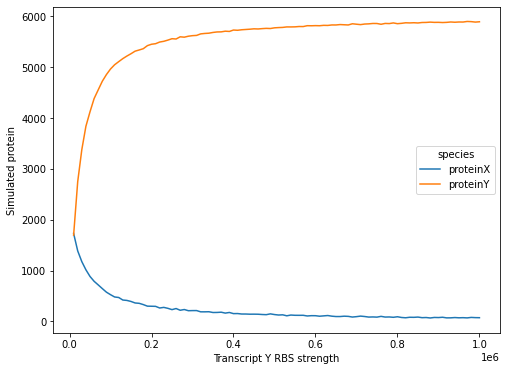

In [29]:
df_protein = df_master[(df_master.species == "proteinX") | (df_master.species == "proteinY")]
rcParams['figure.figsize'] = [8, 6]
g = sns.lineplot(data=df_protein, x="rbs_rate_2", y="protein", hue="species")
plt.xlabel("Transcript Y RBS strength")
plt.ylabel("Simulated protein")

Text(0, 0.5, 'Species counts')

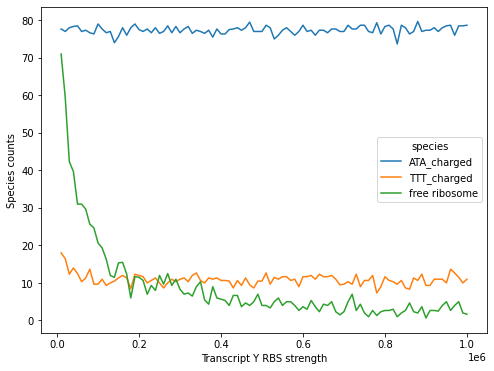

In [28]:
df_species = df_master[(df_master.species == "free ribosome") | (df_master.species == "TTT_charged") | (df_master.species == "ATA_charged")]
rcParams['figure.figsize'] = [8, 6]
sns.lineplot(data=df_species, x="rbs_rate_2", y="protein", hue="species")
plt.xlabel("Transcript Y RBS strength")
plt.ylabel("Species counts")